In [1]:
import findspark

findspark.init('/opt/spark')

## Data Loading

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('final_moynihanl').getOrCreate()

22/05/08 20:42:12 WARN Utils: Your hostname, GPUServer resolves to a loopback address: 127.0.1.1; using 10.4.10.8 instead (on interface enp2s0)
22/05/08 20:42:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/05/08 20:42:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/08 20:42:13 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/05/08 20:42:13 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/05/08 20:42:13 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


In [3]:
from pyspark import SparkFiles



data = spark.read.csv('hdfs://localhost:9000/ds420_shared/EtownDataGroupAsCategory.csv',
                      inferSchema = True, 
                      header = True)

data.show()

+-----+--------------------+
|Label|            Question|
+-----+--------------------+
|    0|When was Elizabet...|
|    1|How many students...|
|    2|Where is Elizabet...|
|    3|What division is ...|
|    4|How much does it ...|
|    5|How big is Etown?...|
|    6|Are there fratern...|
|    7|What majors are p...|
|    8|How big are the c...|
|    9|Are your professo...|
|   10|When does Etown s...|
|   11|What is somehting...|
|   12|What are fun thin...|
|   13|What is the accep...|
|   14|How often are col...|
|   15|Does your major r...|
|   16|Is it popular to ...|
|   17|What's it like to...|
|   18|What is the food ...|
|   19|How are the dorms...|
+-----+--------------------+
only showing top 20 rows



## Data Preprocessing

In [4]:
from pyspark.sql.functions import lower

lower_data = data.withColumn('Question_Lower', lower(data['Question']))
lower_data = lower_data.select(['Label', 'Question_Lower'])

lower_data.show(5)

+-----+--------------------+
|Label|      Question_Lower|
+-----+--------------------+
|    0|when was elizabet...|
|    1|how many students...|
|    2|where is elizabet...|
|    3|what division is ...|
|    4|how much does it ...|
+-----+--------------------+
only showing top 5 rows



In [5]:
df = lower_data.toPandas()

In [6]:
a = df.groupby('Label').Question_Lower.apply(lambda x: x.str.split().str.len().mean())
a

Label
0     199.0
1      86.0
2      49.0
3      96.0
4     299.0
5      14.0
6      50.0
7     125.0
8     160.0
9      99.0
10     11.0
11     33.0
12    163.0
13     49.0
14     68.0
15     42.0
16     12.0
17    274.0
18     51.0
19     40.0
20      6.0
21    149.0
22     44.0
23     44.0
24     17.0
25    276.0
26      7.0
27     30.0
Name: Question_Lower, dtype: float64

<AxesSubplot:xlabel='Label'>

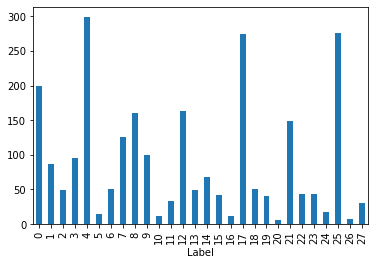

In [7]:
a.plot(kind='bar')


## Tokenization (RegexTokenizer)

In [8]:
from pyspark.ml.feature import Tokenizer, RegexTokenizer
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType

In [9]:

regexTokenizer = RegexTokenizer(inputCol = 'Question_Lower', outputCol = 'words',
                               pattern = '\\W')

In [10]:
countTokens = F.udf(lambda words: len(words), IntegerType())

In [11]:
regexTokenized = regexTokenizer.transform(lower_data)

regexTokenized.select(['Question_Lower', 'words']).withColumn('tokens', countTokens(regexTokenized['words'])).show()

+--------------------+--------------------+------+
|      Question_Lower|               words|tokens|
+--------------------+--------------------+------+
|when was elizabet...|[when, was, eliza...|   200|
|how many students...|[how, many, stude...|    86|
|where is elizabet...|[where, is, eliza...|    49|
|what division is ...|[what, division, ...|    96|
|how much does it ...|[how, much, does,...|   299|
|how big is etown?...|[how, big, is, et...|    14|
|are there fratern...|[are, there, frat...|    50|
|what majors are p...|[what, majors, ar...|   124|
|how big are the c...|[how, big, are, t...|   160|
|are your professo...|[are, your, profe...|   101|
|when does etown s...|[when, does, etow...|    11|
|what is somehting...|[what, is, someht...|    33|
|what are fun thin...|[what, are, fun, ...|   166|
|what is the accep...|[what, is, the, a...|    49|
|how often are col...|[how, often, are,...|    68|
|does your major r...|[does, your, majo...|    41|
|is it popular to ...|[is, it, 

## Stopword Creation

In [12]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

stop_words.append('elizabethtown')
stop_words.append('etown')
stop_words.append('college')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/moynihanl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [14]:
from pyspark.ml.feature import StopWordsRemover

In [15]:
remover = StopWordsRemover(inputCol='words', outputCol='no_stop_words', stopWords=stop_words)

tokenized_no_stop = remover.transform(regexTokenized)

tokenized_no_stop.show(5)

+-----+--------------------+--------------------+--------------------+
|Label|      Question_Lower|               words|       no_stop_words|
+-----+--------------------+--------------------+--------------------+
|    0|when was elizabet...|[when, was, eliza...|[first, opened, o...|
|    1|how many students...|[how, many, stude...|[many, students, ...|
|    2|where is elizabet...|[where, is, eliza...|[located, state, ...|
|    3|what division is ...|[what, division, ...|[division, sports...|
|    4|how much does it ...|[how, much, does,...|[much, cost, atte...|
+-----+--------------------+--------------------+--------------------+
only showing top 5 rows



## Weight Calculations

In [33]:
class_amts = list(tok_stop_cnt.toPandas()['no_stop_tokens'])
class_amts

[59,
 44,
 8,
 32,
 122,
 4,
 12,
 47,
 61,
 39,
 4,
 10,
 49,
 20,
 36,
 20,
 6,
 94,
 14,
 20,
 1,
 69,
 17,
 10,
 4,
 105,
 4,
 12]

In [34]:
from matplotlib import pyplot as plt


<BarContainer object of 28 artists>

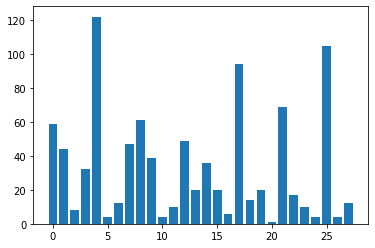

In [35]:
plt.bar(range(28),class_amts) #Words per class (no_stop_words)

In [36]:
max_token = max(list(tok_stop_cnt.toPandas()['no_stop_tokens']))

## Token Count Comparison

In [37]:
tok_stop_cnt = tokenized_no_stop.select(['Label', 'Question_Lower', 'words', 'no_stop_words'])\
    .withColumn('words_tokens', countTokens(tokenized_no_stop['words']))\
    .withColumn('no_stop_tokens', countTokens(tokenized_no_stop['no_stop_words']))

tok_stop_cnt.show()

+-----+--------------------+--------------------+--------------------+------------+--------------+
|Label|      Question_Lower|               words|       no_stop_words|words_tokens|no_stop_tokens|
+-----+--------------------+--------------------+--------------------+------------+--------------+
|    0|when was elizabet...|[when, was, eliza...|[first, opened, o...|         200|            59|
|    1|how many students...|[how, many, stude...|[many, students, ...|          86|            44|
|    2|where is elizabet...|[where, is, eliza...|[located, state, ...|          49|             8|
|    3|what division is ...|[what, division, ...|[division, sports...|          96|            32|
|    4|how much does it ...|[how, much, does,...|[much, cost, atte...|         299|           122|
|    5|how big is etown?...|[how, big, is, et...|[big, big, studen...|          14|             4|
|    6|are there fratern...|[are, there, frat...|[fraternities, so...|          50|            12|
|    7|wha

## Adding in weights

In [38]:
tok_stop_cnt_weighted = tok_stop_cnt.withColumn('Weights', max_token / tok_stop_cnt['no_stop_tokens'])

tok_stop_cnt_weighted.show()

+-----+--------------------+--------------------+--------------------+------------+--------------+------------------+
|Label|      Question_Lower|               words|       no_stop_words|words_tokens|no_stop_tokens|           Weights|
+-----+--------------------+--------------------+--------------------+------------+--------------+------------------+
|    0|when was elizabet...|[when, was, eliza...|[first, opened, o...|         200|            59|2.0677966101694913|
|    1|how many students...|[how, many, stude...|[many, students, ...|          86|            44| 2.772727272727273|
|    2|where is elizabet...|[where, is, eliza...|[located, state, ...|          49|             8|             15.25|
|    3|what division is ...|[what, division, ...|[division, sports...|          96|            32|            3.8125|
|    4|how much does it ...|[how, much, does,...|[much, cost, atte...|         299|           122|               1.0|
|    5|how big is etown?...|[how, big, is, et...|[big, b

## Wordcloud

In [39]:
panda = tok_stop_cnt_weighted.toPandas()

In [40]:
panda

,Label,Question_Lower,words,no_stop_words,words_tokens,no_stop_tokens,Weights
0,0,when was elizabethtown college first opened? w...,"[when, was, elizabethtown, college, first, ope...","[first, opened, opened, originally, founded, f...",200,59,2.067797
1,1,how many students attend elizabethtown college...,"[how, many, students, attend, elizabethtown, c...","[many, students, attend, many, students, go, m...",86,44,2.772727
2,2,where is elizabethtown college located? where ...,"[where, is, elizabethtown, college, located, w...","[located, state, address, state, part, pennsyl...",49,8,15.250000
3,3,what division is etown sports? what elizabetht...,"[what, division, is, etown, sports, what, eliz...","[division, sports, division, sports, sports, d...",96,32,3.812500
4,4,how much does it cost to attend elizabethtown ...,"[how, much, does, it, cost, to, attend, elizab...","[much, cost, attend, much, cost, go, much, cos...",299,122,1.000000
5,5,how big is etown? how big is elizabethtown col...,"[how, big, is, etown, how, big, is, elizabetht...","[big, big, student, populatin]",14,4,30.500000
6,6,are there fraternities or sororities at etown?...,"[are, there, fraternities, or, sororities, at,...","[fraternities, sororities, frats, sorotities, ...",50,12,10.166667
7,7,what majors are popular at etown? what are the...,"[what, majors, are, popular, at, etown, what, ...","[majors, popular, majors, departments, program...",124,47,2.595745
8,8,how big are the classes? how many kids are in ...,"[how, big, are, the, classes, how, many, kids,...","[big, classes, many, kids, classroom, average,...",160,61,2.000000
9,9,are your professors good teachers? do the prof...,"[are, your, professors, good, teachers, do, th...","[professors, good, teachers, professors, hold,...",101,39,3.128205


In [41]:
panda["Weights"]

0       2.067797
1       2.772727
2      15.250000
3       3.812500
4       1.000000
5      30.500000
6      10.166667
7       2.595745
8       2.000000
9       3.128205
10     30.500000
11     12.200000
12      2.489796
13      6.100000
14      3.388889
15      6.100000
16     20.333333
17      1.297872
18      8.714286
19      6.100000
20    122.000000
21      1.768116
22      7.176471
23     12.200000
24     30.500000
25      1.161905
26     30.500000
27     10.166667
Name: Weights, dtype: float64

In [46]:
import seaborn as sns

<AxesSubplot:xlabel='Label', ylabel='Weights'>

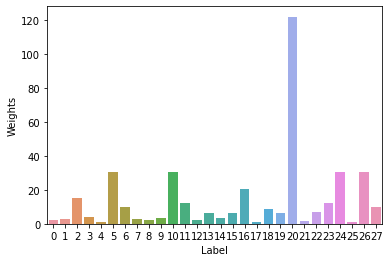

In [47]:
sns.barplot(y = 'Weights',
            x = 'Label',
            data = panda)

In [49]:
from wordcloud import WordCloud 

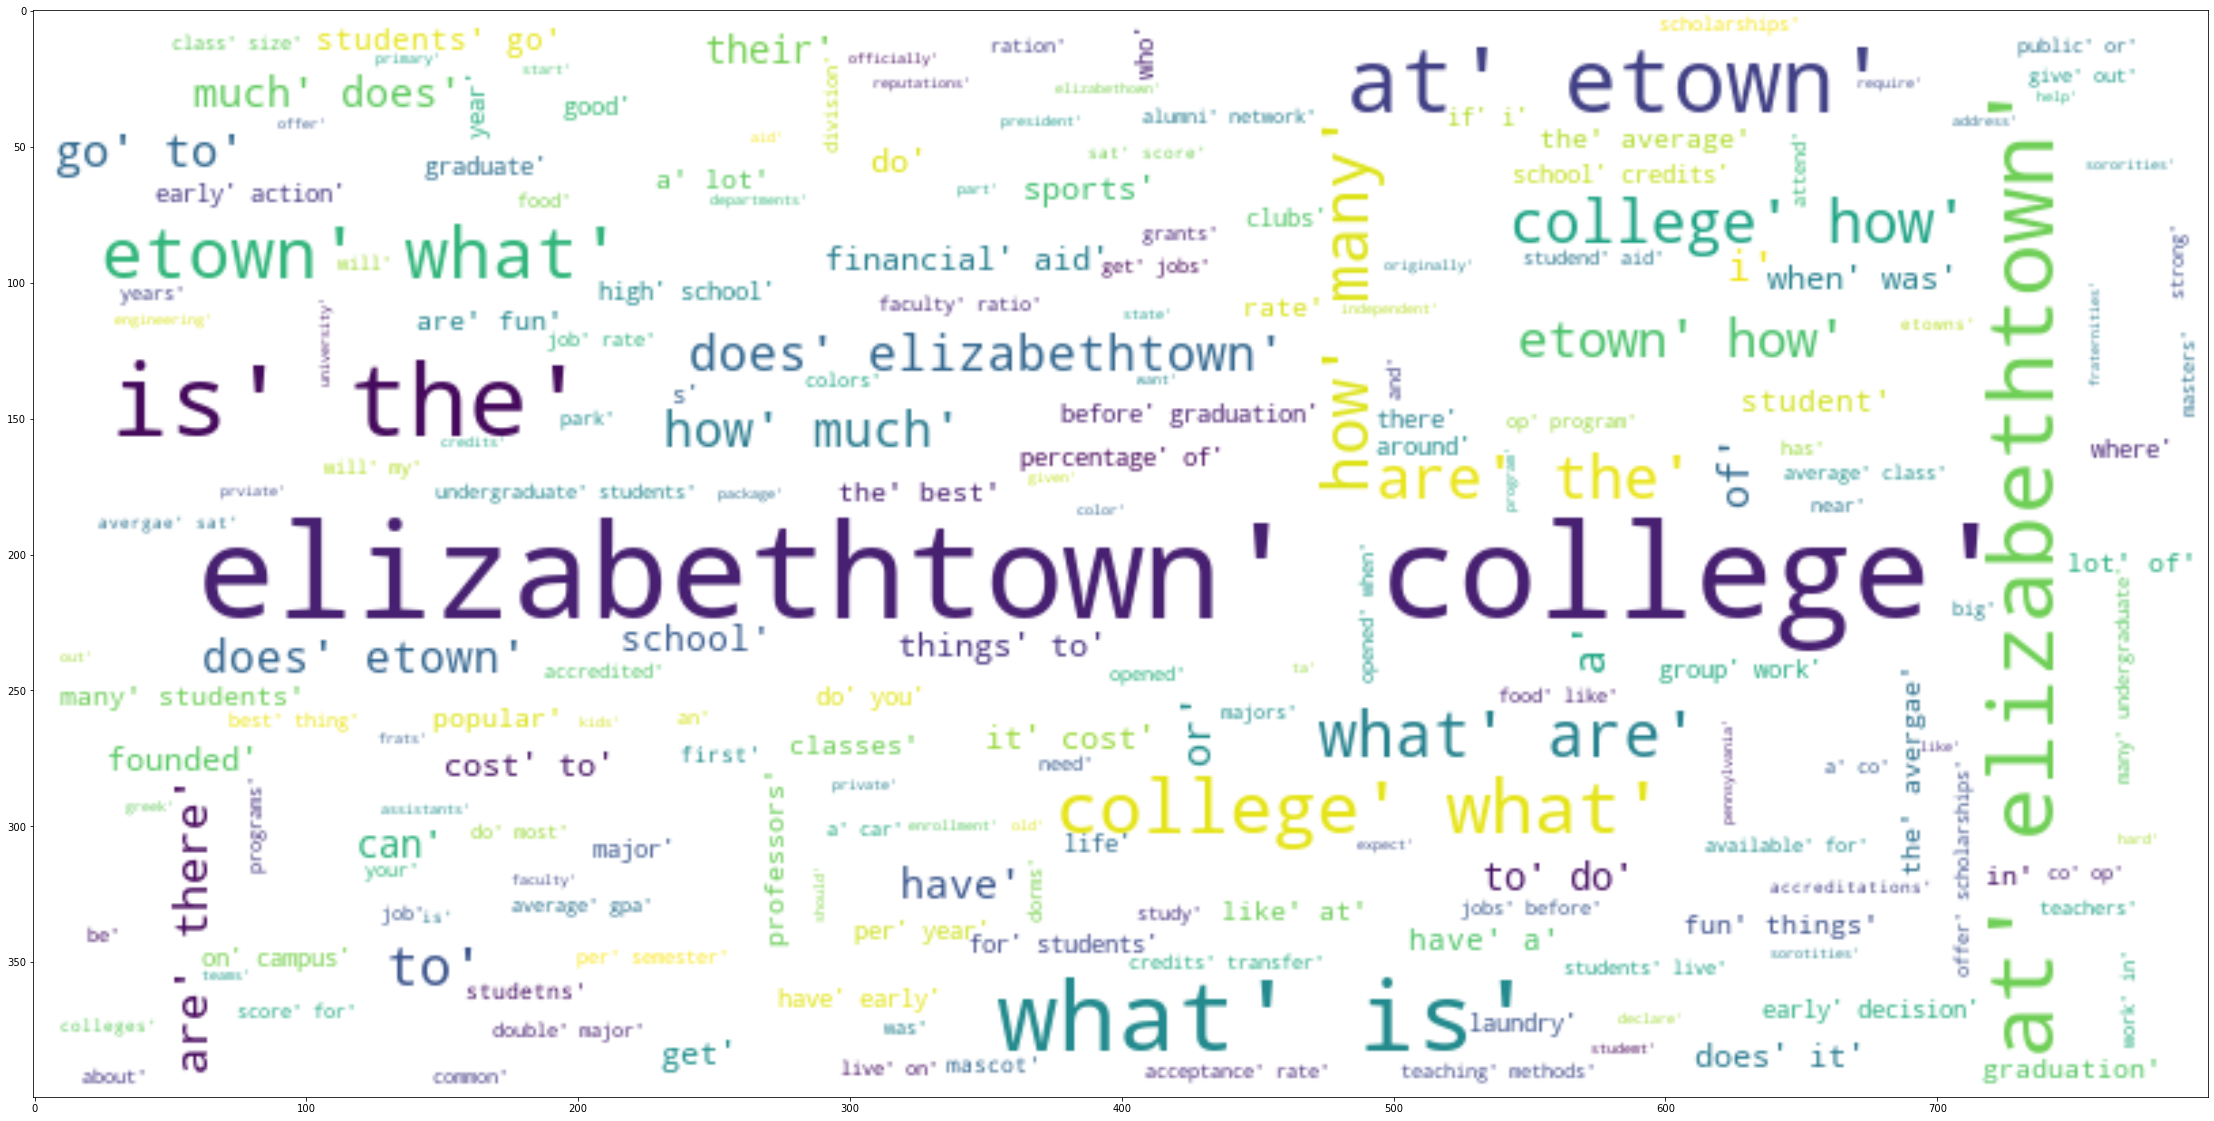

In [50]:
text = " ".join(review for review in panda.words.astype(str))

# Create stopword list:
# remove words that we want to exclude

# Generate a word cloud image

wordcloud = WordCloud(stopwords=stop_words, background_color="white", width=800, height=400).generate(text)

# Display the generated image:
# the matplotlib way:

plt.figure( figsize=(40,20))
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

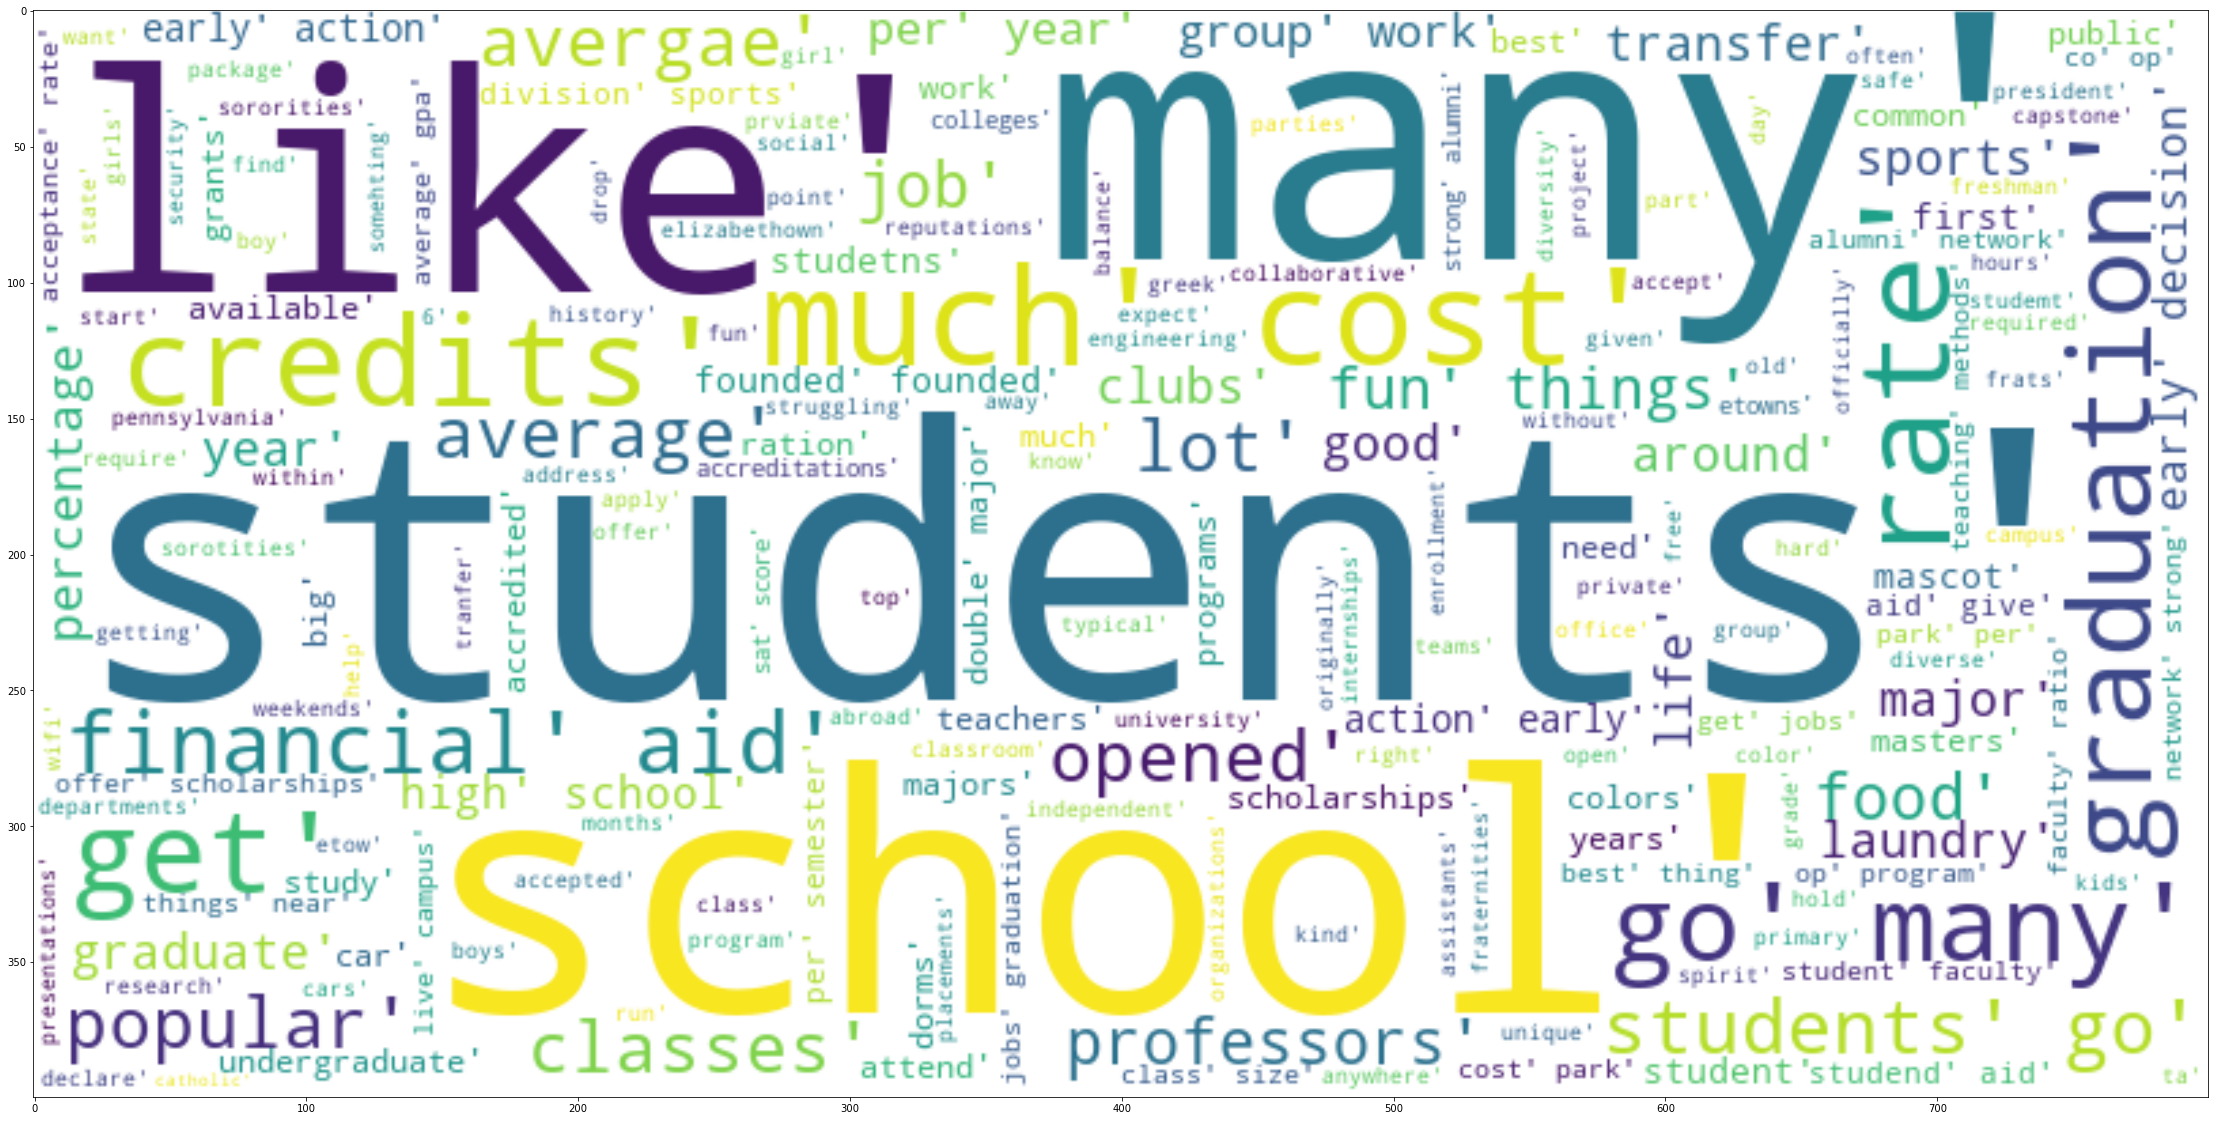

In [51]:
text = " ".join(review for review in panda.no_stop_words.astype(str))

# Create stopword list:
# remove words that we want to exclude

# Generate a word cloud image

wordcloud = WordCloud(stopwords=stop_words, background_color="white", width=800, height=400).generate(text)

# Display the generated image:
# the matplotlib way:


plt.figure( figsize=(40,20))
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

## Doc-Term_Frequency

In [108]:
from pyspark.ml.feature import HashingTF, IDF    # mathematical matrix that describes the frequency of terms that occur in a collection of documents. 

In [109]:
hashingTF = HashingTF(inputCol='no_stop_words', outputCol='tf', numFeatures = 1000)

tfData = hashingTF.transform(tok_stop_cnt_weighted.select('Label', 'no_stop_words', 'Weights'))

In [110]:
idf = IDF(inputCol = 'tf', outputCol = 'tfidf', minDocFreq = 3)

idfModel = idf.fit(tfData)

rescaledData = idfModel.transform(tfData)

In [111]:
rescaledData.columns

['Label', 'no_stop_words', 'Weights', 'tf', 'tfidf']

In [112]:
tfidf = rescaledData.select(['Label', 'tfidf', 'Weights'])

tfidf.show(28)

+-----+--------------------+------------------+
|Label|               tfidf|           Weights|
+-----+--------------------+------------------+
|    0|(1000,[58,76,83,9...|2.0677966101694913|
|    1|(1000,[67,188,405...| 2.772727272727273|
|    2|(1000,[21,440,454...|             15.25|
|    3|(1000,[180,288,40...|            3.8125|
|    4|(1000,[17,67,298,...|               1.0|
|    5|(1000,[48,536,760...|              30.5|
|    6|(1000,[84,297,477...|10.166666666666666|
|    7|(1000,[19,40,58,7...| 2.595744680851064|
|    8|(1000,[7,19,35,48...|               2.0|
|    9|(1000,[19,168,319...| 3.128205128205128|
|   10|(1000,[679,996],[...|              30.5|
|   11|(1000,[350,602,76...|              12.2|
|   12|(1000,[7,133,197,...| 2.489795918367347|
|   13|(1000,[168,188,19...|               6.1|
|   14|(1000,[7,32,43,26...| 3.388888888888889|
|   15|(1000,[58,116,145...|               6.1|
|   16|(1000,[148,224,63...|20.333333333333332|
|   17|(1000,[7,17,44,73...| 1.297872340

In [113]:
from pyspark.ml.classification import NaiveBayes

## NaiveBayes

In [114]:
nb = NaiveBayes(featuresCol='tfidf', labelCol='Label', weightCol='Weights')

nb_fit = nb.fit(tfidf)

predictions = nb_fit.transform(tfidf)

In [115]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [116]:
evaluator = MulticlassClassificationEvaluator(labelCol='Label', predictionCol='prediction')

evaluator.evaluate(predictions)

0.8714285714285711

## LogisticRegression

In [95]:
from pyspark.ml.classification import LogisticRegression

In [96]:
tfidf.show()

+-----+--------------------+
|Label|               tfidf|
+-----+--------------------+
|    0|(1000,[58,76,83,9...|
|    1|(1000,[67,188,405...|
|    2|(1000,[21,440,454...|
|    3|(1000,[180,288,40...|
|    4|(1000,[17,67,298,...|
|    5|(1000,[48,536,760...|
|    6|(1000,[84,297,477...|
|    7|(1000,[19,40,58,7...|
|    8|(1000,[7,19,35,48...|
|    9|(1000,[19,168,319...|
|   10|(1000,[679,996],[...|
|   11|(1000,[350,602,76...|
|   12|(1000,[7,133,197,...|
|   13|(1000,[168,188,19...|
|   14|(1000,[7,32,43,26...|
|   15|(1000,[58,116,145...|
|   16|(1000,[148,224,63...|
|   17|(1000,[7,17,44,73...|
|   18|(1000,[168,330,65...|
|   19|(1000,[188,320,33...|
+-----+--------------------+
only showing top 20 rows



In [97]:
log_reg_ = LogisticRegression(featuresCol = 'tfidf', labelCol = 'Label', weightCol="Weights",family="multinomial")

In [98]:
Model = log_reg_.fit(tfidf)

In [99]:
predictions = Model.transform(tfidf)

In [101]:
evaluator = MulticlassClassificationEvaluator(labelCol='Label', predictionCol='prediction')

evaluator.evaluate(predictions)

0.9107142857142854

## Random Forest

In [102]:
from pyspark.ml.classification import RandomForestClassifier


In [103]:
rf = RandomForestClassifier(featuresCol = 'tfidf', labelCol = 'Label', weightCol="Weights", numTrees=5)


In [104]:
model = rf.fit(tfidf)


22/05/08 20:52:56 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 28 (= number of training instances)


In [105]:
predictions = model.transform(tfidf)

In [106]:
evaluator = MulticlassClassificationEvaluator(labelCol='Label', predictionCol='prediction')

evaluator.evaluate(predictions)

0.13184523809523807

In [118]:
import numpy as np

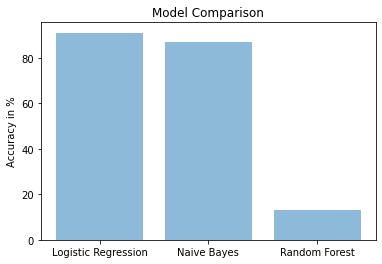

In [119]:
objects = ('Logistic Regression', 'Naive Bayes', 'Random Forest')
y_pos = np.arange(len(objects))
performance = [91.07,87.14,13.18]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy in %')
plt.title('Model Comparison')

plt.show()

## Good Job!